# target encoder & ohe & xDeepFM - basic

In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath('..'))
# ---------------------------------
from time import sleep
import numpy as np
import pandas as pd
import scipy
import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.metrics import roc_auc_score

from hyperopt import hp
# ---------------------------------
from tools import CV, Tuning, CVGetScore, IdxValEncoder, xdeepfm, CyclicLR, MaxLrFinder
# ---------------------------------
from tools import focal_loss, gelu, mish
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({'focal_loss': focal_loss()})
get_custom_objects().update({'mish': mish})
get_custom_objects().update({'gelu': gelu})

In [2]:
train_df = pd.read_csv('../data/train.csv', index_col='id')
test_df = pd.read_csv('../data/test.csv', index_col='id')

# ord_5
for i in range(2):
    train_df[f'ord_5_{i}'] = train_df['ord_5'].str[i]
    test_df[f'ord_5_{i}'] = test_df['ord_5'].str[i]

# null
train_df['null'] = train_df.isna().sum(axis=1)
test_df['null'] = test_df.isna().sum(axis=1)

for col in test_df.columns:
    train_df[col].fillna('isnull', inplace=True)
    test_df[col].fillna('isnull', inplace=True)

# target
target = train_df['target']
y_train = target.values

# drop
train_df.drop(['target', 'ord_5'], axis=1, inplace=True)
test_df.drop(['ord_5'], axis=1, inplace=True)

In [3]:
feature_col = train_df.columns

bin_col = ['null']

class_col = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
             'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4',
             'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
             'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4',
             'day', 'month', 'ord_5_0', 'ord_5_1']

In [4]:
# for col in bin_col:
#     map_dict = dict(zip(train_df[col].unique(), [0., 1.]))
#     train_df[col] = train_df[col].map(map_dict)
#     test_df[col] = test_df[col].map(map_dict)

In [5]:
ecd = IdxValEncoder(feature_col, bin_col=bin_col, class_col=class_col)
ecd.fit(train_df, verbose=1)

600000it [00:10, 55674.48it/s]


In [6]:
ecd.fit(test_df, verbose=1)

400000it [00:07, 54867.83it/s]


In [7]:
idx, val = ecd.transform(train_df, verbose=1)
idx_test, val_test = ecd.transform(test_df, verbose=1)

600000it [00:13, 44991.02it/s]
400000it [00:08, 46904.75it/s]


# Search Max LR

In [19]:
%%time

tf.keras.backend.clear_session()

batch_size = 1024
epochs = 5
nflold = 5

model_param = {'vocabulary_size':ecd.get_vocabulary(), 
               'feature_number': len(feature_col),
               'activation': 'sigmoid',
               'metrics': ['AUC'],
               'optimizer': 'Adam',
               'loss': 'binary_crossentropy'}

mf = MaxLrFinder(1e-6, 1e-1, epochs=epochs, batch_size=batch_size, sample_length=train_df.shape[0]*((nflold-1)/nflold))
fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[mf]}

model = xdeepfm(**model_param)

cv = CV(model, nflold)

score = cv.fit(x=[idx, val],
               y=y_train, 
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size':batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)


Train on 480000 samples, validate on 120000 samples
Epoch 1/5
480000/480000 [==============================] - 31s 65us/sample - loss: 0.6886 - AUC: 0.4953 - val_loss: 0.6703 - val_AUC: 0.4963
Epoch 2/5
480000/480000 [==============================] - 30s 63us/sample - loss: 0.5718 - AUC: 0.5079 - val_loss: 0.4630 - val_AUC: 0.6931
Epoch 3/5
480000/480000 [==============================] - 30s 63us/sample - loss: 0.4117 - AUC: 0.7627 - val_loss: 0.4000 - val_AUC: 0.7824
Epoch 4/5
480000/480000 [==============================] - 30s 63us/sample - loss: 0.3996 - AUC: 0.7824 - val_loss: 0.4027 - val_AUC: 0.7788
Epoch 5/5
480000/480000 [==============================] - 30s 63us/sample - loss: 0.7354 - AUC: 0.7645 - val_loss: 5.6150 - val_AUC: 0.7737
folds 0 is done, score is 0.7737062466503711
Train on 480000 samples, validate on 120000 samples
Epoch 1/5
480000/480000 [==============================] - 31s 66us/sample - loss: 0.6758 - AUC: 0.4967 - val_loss: 0.6420 - val_AUC: 0.5015
Epoch

In [20]:
tf.keras.backend.clear_session()

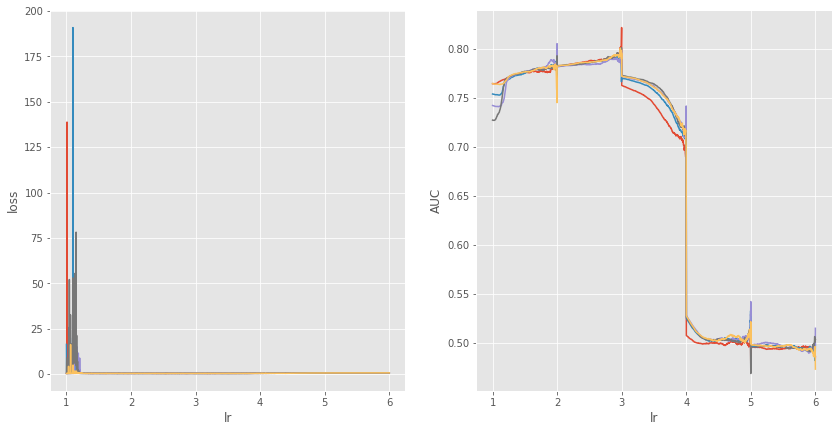

In [21]:
mf.plot(True)

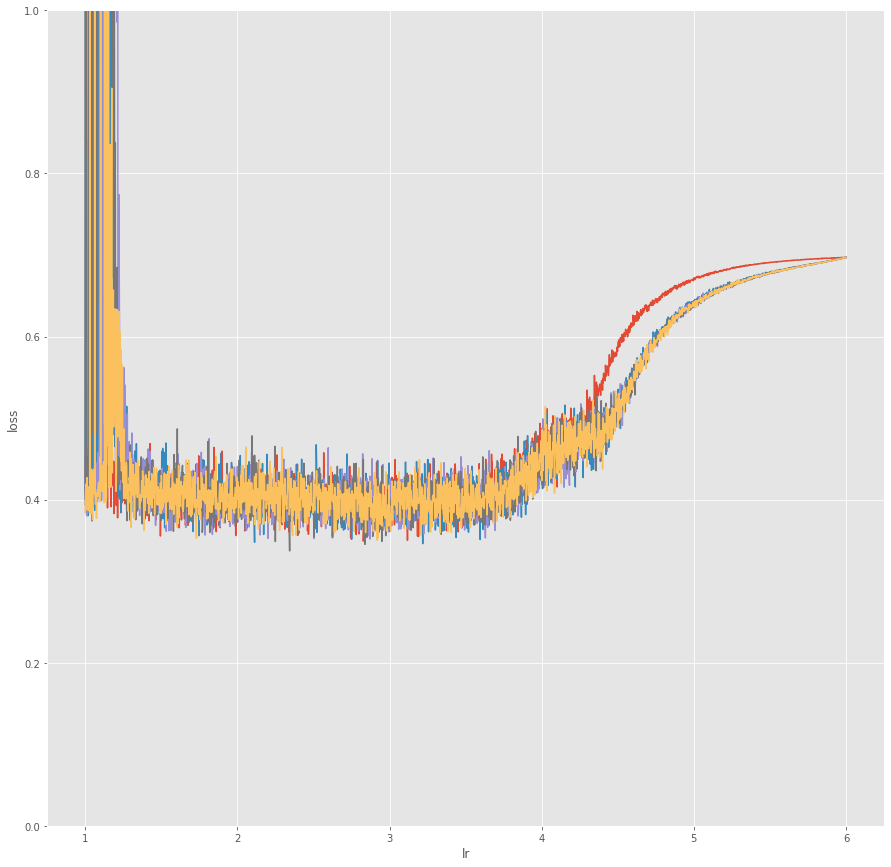

In [22]:
import math
result_dict = mf.get_result()
lr_func = lambda t: mf.min_lr * mf.rate ** t
lr_list = [math.log(lr_func(t), 0.1) for t in range(mf.batch_id[0])]
# loc

plt.figure(figsize=[15, 15])
loss_val = result_dict['loss']
for sub_res in loss_val:
    plt.plot(lr_list, sub_res)
    plt.xlabel('lr')
    plt.ylim(0, 1)
    plt.ylabel('loss')

# fit one

In [16]:
%%time

batch_size = 512
epochs = 100
nflod = 5

model_param = {'vocabulary_size':ecd.get_vocabulary(), 
               'feature_number': len(feature_col),
               'activation': 'sigmoid',
               'metrics': ['AUC'],
               'optimizer': 'Adam',
               'loss': 'binary_crossentropy'}

clr = CyclicLR(base_lr=2e-5,
               max_lr=5e-4, 
               step_size=int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='exp_range',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=3, mode='max', restore_best_weights=True)

fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[es, clr]}

model = xdeepfm(**model_param)

cv = CV(model, nflod)

score = cv.fit(x=[idx, val],
               y=y_train, 
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size':batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)

tf.keras.backend.clear_session()

Train on 480000 samples, validate on 120000 samples
Epoch 1/100
480000/480000 [==============================] - 32s 67us/sample - loss: 0.5381 - AUC: 0.5465 - val_loss: 0.4260 - val_AUC: 0.7446
Epoch 2/100
480000/480000 [==============================] - 30s 63us/sample - loss: 0.4038 - AUC: 0.7762 - val_loss: 0.3980 - val_AUC: 0.7853
Epoch 3/100
480000/480000 [==============================] - 30s 63us/sample - loss: 0.3936 - AUC: 0.7916 - val_loss: 0.3965 - val_AUC: 0.7874
Epoch 4/100
480000/480000 [==============================] - 30s 63us/sample - loss: 0.3917 - AUC: 0.7943 - val_loss: 0.3969 - val_AUC: 0.7866
Epoch 5/100
480000/480000 [==============================] - 30s 63us/sample - loss: 0.3905 - AUC: 0.7961 - val_loss: 0.3970 - val_AUC: 0.7871
Epoch 6/100
480000/480000 [==============================] - 30s 63us/sample - loss: 0.3887 - AUC: 0.7987 - val_loss: 0.3972 - val_AUC: 0.7865
folds 0 is done, score is 0.78740785992131
Train on 480000 samples, validate on 120000 sam

In [17]:
score

0.787243275393794

# Tuning

In [ ]:
%matplotlib qt5

batch_size = 8192
epochs = 100
nflod = 5

# fit param

clr = CyclicLR(base_lr=1e-5,
               max_lr = 1e-3, 
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='exp_range',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=3,
                                      mode='max',
                                      restore_best_weights=True)

fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

cv_fit_param = {'fit_params': fit_param, 
                'eval_param': {'batch_size':batch_size},
                'use_proba':False, 
                'fit_use_valid': True}

# model_fix_param & model_search_space
model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam'}

ss = {
    'loss': (hp.choice, ('focal_loss', 'binary_crossentropy')), 
    'deep_activation': (hp.choice, ('relu', 'mish', 'gelu', 'selu')),
    'num_neuron': (hp.choice, (32, 64, 128, 256)),
    'num_deep_layer': (hp.choice, (1, 2, 3, 4)),
    'l2_deep': (hp.loguniform, (-15, 5)),
    'deep_dropout': (hp.uniform, (0, 0.5)),
    'num_cin_layer': (hp.choice, (1, 2, 3, 4)),
    'num_cin_size': (hp.choice, (32, 64, 128, 256)),
    'cin_activation': (hp.choice, ('relu', 'mish', 'gelu', 'selu')),
    'split_half': (hp.choice, (True, False)),
    'l2_cin': (hp.loguniform, (-20, 0)),
    'cin_dropout': (hp.uniform, (0, 0.5)),
}

# cv get score
def neg_auc(y_true, y_pred):
    return - roc_auc_score(y_true, y_pred)

gs = CVGetScore(x=[idx, val],
                y=y_train, 
                metrics_func=neg_auc,
                split_method=StratifiedKFold,
                nfolds=nflod, 
                random_state=2333,
                model=xdeepfm, 
                cv_fit_params=cv_fit_param, 
                model_fix_params=model_fix_param, 
                model_search_space=ss)

tuning = Tuning(gs, verbose=1)
tuning.fmin(gs.GET_SEARCH_SPACE(), max_evals=100)

In [ ]:
tudf = tuning.log.get_log()

In [ ]:
tudf.sort_values('score').head(20)

In [ ]:
tudf.sort_values('score').tail(20)

In [ ]:
%matplotlib inline
tuning.log.plot()

In [ ]:
tuning.log.best_param